# Factorial Hiddon Markov Model
In this notebook, we apply the FHMM disaggregation method implemented in the NILMTK package on the REDD dataset. We then make improvements on the NILMTK implementation and compare the results. For data processing, we use the tools availalble in NILMTK. 

Factorial hidden markov models (FHMM) are generalizations of hidden markov models (HMMs) where the hidden state is factored into multiple state variables (Ghahramani and Jordan, 1997). We first describe the disaggregation problem in terms of HMMs, then describe it in the FHMM framework. 

In this problem, we wish to infer a time series of the hidden states of each appliance in the household. If we only wished to infer the hidden state of one appliance, for example, a refrigerator, we can model it as an HMM. The hidden state would be whether the fridge is on or off. The observed state would be the aggregated energy reading for the entire home. 
$$z_t \rightarrow z_{t+1} \\
\hspace{1mm} \downarrow \hspace{10mm} \downarrow \hspace{1mm} \\
x_t \hspace{6mm} x_{t+1}$$
where $z$ refers to the hidden state and takes on a discrete value (on/off) and $x$ is the observed state and takes on a continuous value. The emission probability, the probability of making an observation $x_t$ given $z_t$, $P(x_t|z_t)$ can be modeled as a Gaussian. 

An FHMM is similar to HMM, but for each observation, instead of having one hidden state, there are multiple hidden states we need to infer. This would be the case if we wanted to infer the status of multiple appliances in the home. We can model this as an HMM with a distinct state for each possible combination of states: fridge on + lights off, fridge on + lights on, etc. Alternatively, we can let the state be represented by a collection of state variables, 
$$z_t = z^1_t, z^2_t, ...$$
each of which can take on an on/off value. In the energy disaggregation problem, the observed state is the sum of the different hidden states (Kolter and Jakkola, 2012). The hidden states are drawn from a multinomial distribution and the transition probability can be factored as: 
$$P(z_t|z_{t-1}) = \Pi_{m=1}^M P(z_t^{(m)}|z_{t-1}^{(m)})$$
The emissions are Gaussian: 
$$ P(x_t|z_t) = \mathcal{N} (\Sigma_{i=1}^{N} \mu^{(i)}, \Sigma)$$
The additive model is a special case of the general FHMM. 

In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore

/Users/kyu/Google Drive/AM207project/nilmtk/nilmtk/node.py:2: ImportWarning: Not importing directory 'nilm_metadata': missing __init__.py
  from nilm_metadata import recursively_update_dict


## Read in data and do data processing
Read in data and separate into training and testing sets using functions available in NILMTK. 

In [3]:
train = DataSet('redd.h5')
test = DataSet('redd.h5')

# we do not use the 4th house because it does not contain a fridge
training_houses = [1,2,3]
test_houses = 5

test_elec = test.buildings[test_houses].elec

# appliances
appliances = ['fridge', 'microwave']

We train with only the k=3 top devices. However, we find that the top devices are not the same for each house. We decided to use fridge, sockets, and light because they are the most common appliances to occur in the top 3 and are present in both the training and test set. 

The appliances have different numbers for each home, presenting difficulties for using the disaggregation algorithms across different houses. We manually set the appliance numbers of the test set to deal with this problem. 

## FHMM implementation in NILMTK
The NILMTK implementation takes the approach of expanding the HMM model state space to have every combination of states of eveyr appliance (eg. fridge on + lights off, fridge on + lights on, etc.). In the NILMTK implementation, we use the train_across_buildings function in the FHMM class. The function takes in the training dataset, and we give it a list of houses and appliances we want to train. The code loops through each appliance, then each building, and checks that the on/off difference are larger than a preset value. The data from all buildings for a particular appliance is modeled as an HMM with two hidden states (on/off) and Gaussian emissions. The package hmmlearn is used to fit the means for the two states. hmmlearn uses EM to fit the parameters. This is done for every appliance, so that for every appliance we have an HMM. The parameters for each appliance are then combined into an FHMM by taking every combination of the possible states for every appliance and summing the power means for each state. 

To perform disaggregation, the predict function of hmmlearn is used, which finds the most likely state sequence that corresponds to a set of observations. hmmlearn has two options for the decoder algorithm, Viterbi and MAP, with Viterbi being the default. 

In [4]:
# train FHMM model
from nilmtk.disaggregate import fhmm_exact
reload(fhmm_exact)
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm.train_across_buildings(train, training_houses, appliances, min_activation=0.001, sample_period=60)

Training for fridge
0.251938355509
0.187561165591
0.15943511758
Means for fridge are
[[ 160.49383619]
 [   5.00965659]]
Training for microwave
0.0180721738298
0.0425612654537
0.00272830147731
Means for microwave are
[[   3.60817999]
 [ 356.40139336]]


In [5]:
# perform disaggregation and save output to file
disag_filename = 'redd-disag-fhmm_exact.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm.disaggregate_across_buildings(test, output, [test_houses], sample_period=60)
output.close()

Disaggregating for building 5


/Users/kyu/Google Drive/AM207project/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"


Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.


In [6]:
# Read disaggreated data 
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

3     0.118409
18    0.250575
dtype: float64
3     0.461538
18    0.190406
dtype: float64
3     0.070209
18    0.195539
dtype: float64
3     0.523707
18    0.350896
dtype: float64


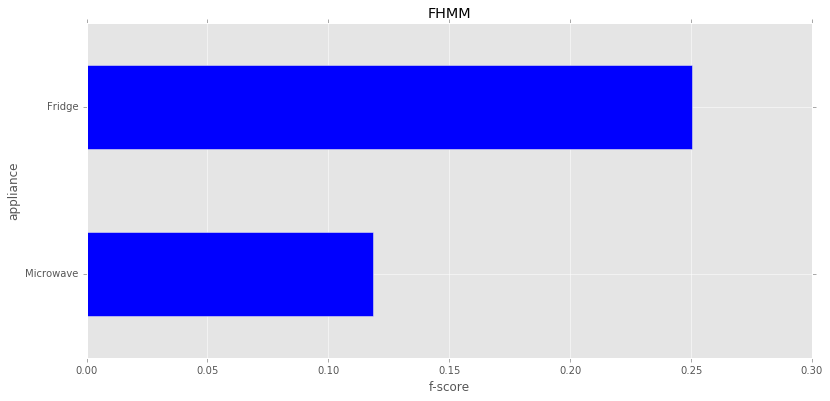

In [7]:
# make plots of f1 score
from nilmtk.metrics import f1_score, accuracy_score, recall_score, precision_score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

3     0.328191
18    0.383347
dtype: float64
3     0.057717
18    0.378460
dtype: float64
3     0.485041
18    0.912296
dtype: float64


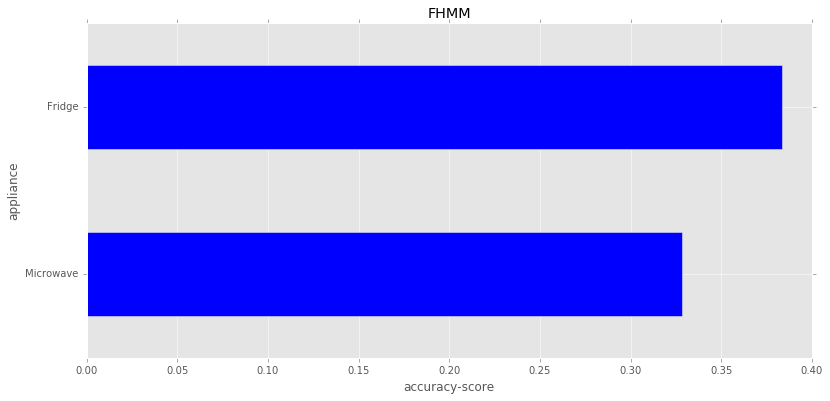

In [30]:
accuracy_fhmm = accuracy_score(disag_fhmm_elec, test_elec)
print(accuracy_fhmm)
accuracy_fhmm.index = disag_fhmm_elec.get_labels(accuracy_fhmm.index)
accuracy_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('accuracy-score');
plt.title("FHMM");

3     0.057717
18    0.378460
dtype: float64


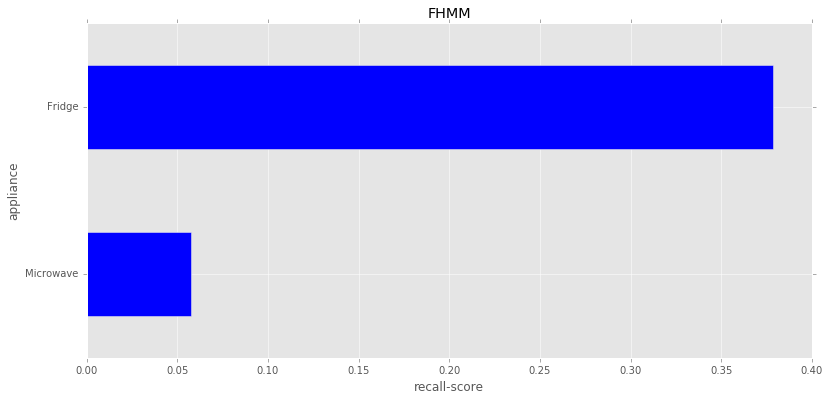

In [31]:
recall_fhmm = recall_score(disag_fhmm_elec, test_elec)
print(recall_fhmm)
recall_fhmm.index = disag_fhmm_elec.get_labels(recall_fhmm.index)
recall_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

3     0.485041
18    0.912296
dtype: float64


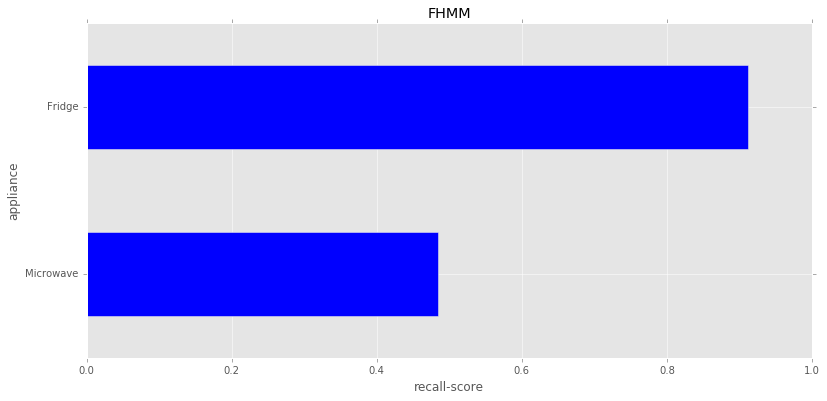

In [32]:
precision_fhmm = precision_score(disag_fhmm_elec, test_elec)
print(precision_fhmm)
precision_fhmm.index = disag_fhmm_elec.get_labels(precision_fhmm.index)
precision_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

## Improved FHMM implementation: increasing number of hidden states
There are actually two NILMTK FHMM implementations, one for within the same building and one for across buildings. In the implementation for within the same building, depending on the amount of data available, there is the option to have 2 or 3 states. The third state accounts for an ambiguous state that represents an intermediate between the on and off states, or when the device is operating at a lower energy state. THe train_across_buildings method was altered to have 3 states to see if this improves results. 

In [8]:
from nilmtk.disaggregate import fhmm_3
reload(fhmm_3)
fhmm3 = fhmm_3.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm3.train_across_buildings(train, training_houses, appliances, sample_period=60, min_activation=0.001)

Training for fridge
Means for fridge are
[[   5.02342541]
 [ 154.48833389]
 [ 407.85845772]]
Training for microwave
Means for microwave are
[[   3.61560591]
 [ 904.70409834]
 [  39.21034185]]


In [9]:
disag_filename = 'redd-disag-fhmm_3.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm3.disaggregate_across_buildings(test, output, [test_houses], sample_period=60)
output.close()

Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading da

3     0.099109
18    0.532885
dtype: float64
3     0.328191
18    0.383347
dtype: float64
3     0.057717
18    0.378460
dtype: float64
3     0.485041
18    0.912296
dtype: float64


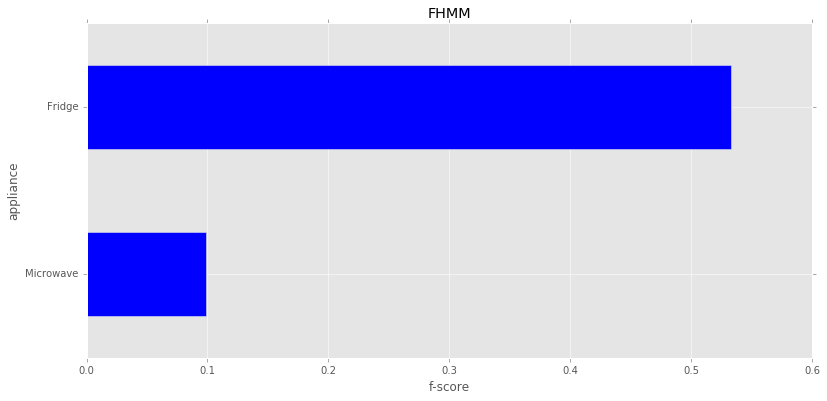

In [10]:
# Read disaggreated data
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

# make plots of f1 score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

3     0.328191
18    0.383347
dtype: float64


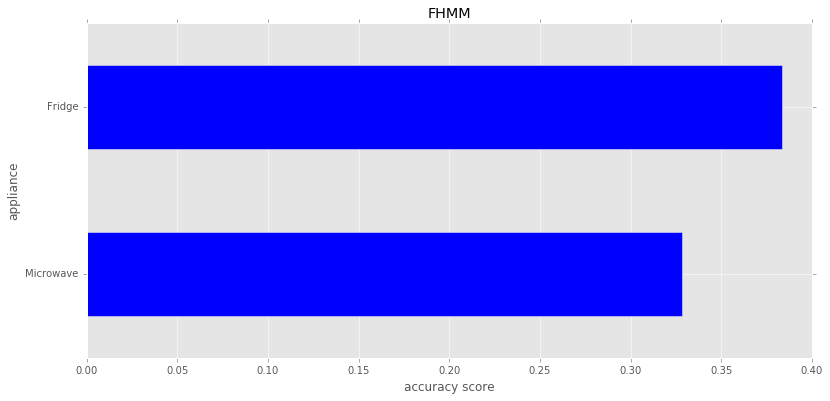

In [9]:
# make plots of f1 score
from nilmtk.metrics import accuracy_score
accuracy_fhmm = accuracy_score(disag_fhmm_elec, test_elec)
print(accuracy_fhmm)
accuracy_fhmm.index = disag_fhmm_elec.get_labels(accuracy_fhmm.index)
accuracy_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('accuracy score');
plt.title("FHMM");

3     0.057717
18    0.378460
dtype: float64


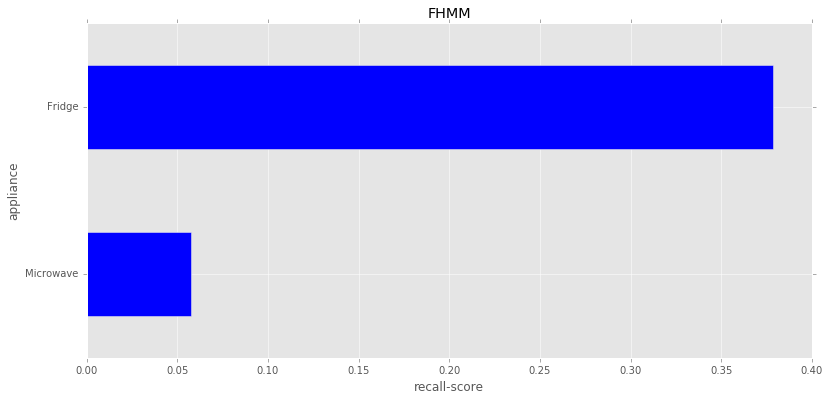

In [33]:
recall_fhmm = recall_score(disag_fhmm_elec, test_elec)
print(recall_fhmm)
recall_fhmm.index = disag_fhmm_elec.get_labels(recall_fhmm.index)
recall_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

3     0.485041
18    0.912296
dtype: float64


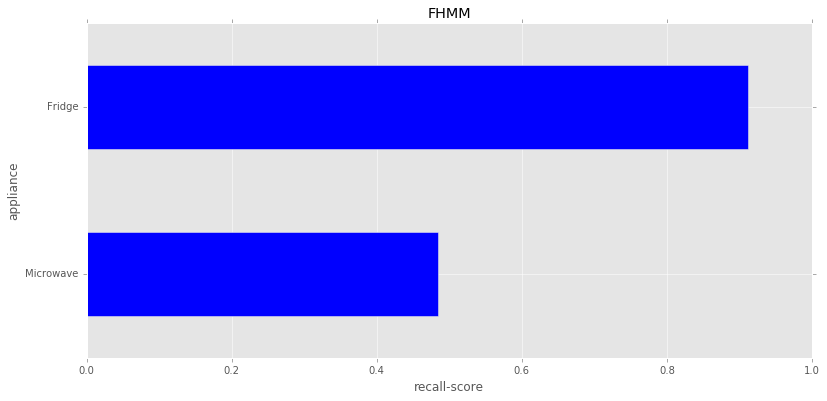

In [34]:
precision_fhmm = precision_score(disag_fhmm_elec, test_elec)
print(precision_fhmm)
precision_fhmm.index = disag_fhmm_elec.get_labels(precision_fhmm.index)
precision_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('recall-score');
plt.title("FHMM");

## Improved FHMM implementation: using Gaussian mixtures as emission
The emission probabilties in the NILMTK implementation are Gaussian. This means that given a certain hidden state, the probability of the meter reading follows a Gaussian distribution. An alternative is to model the emissions as a Gaussian Mixture. This has the potential to improve the model because we are only inferring the hidden states of two appliances, but the mains reading will include appliances that the model is not trained on. So for example, when the fridge is on, the observed signal can be multi-modal. 

In [29]:
from nilmtk.disaggregate import fhmm_improved
reload(fhmm_improved)
fhmm2 = fhmm_improved.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm2.train_across_buildings(train, training_houses, ['fridge', 'microwave'], sample_period=60, min_activation=0.001)

Training for fridge


TypeError: __init__() got an unexpected keyword argument 'verbose'

In [108]:
output.close()
disag_filename = 'redd-disag-fhmm_gmm2.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm2.disaggregate_across_buildings(test, output, [test_houses], sample_period=60)
output.close()

Disaggregating for building 5
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading da

NotFittedError: This GMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

4     0.000000
5     0.155093
18    0.589505
dtype: float64


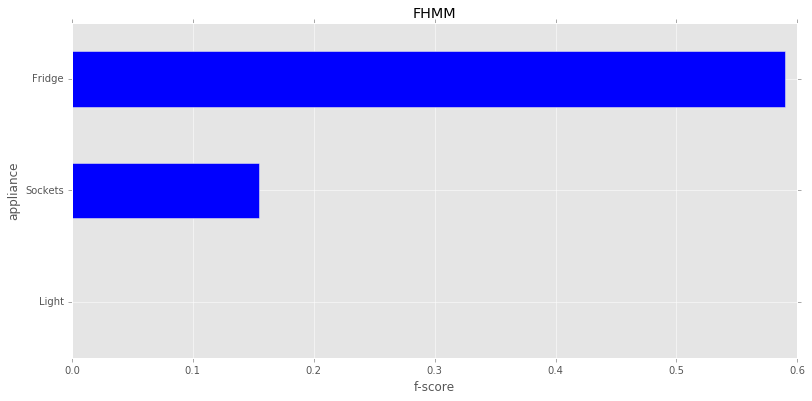

In [104]:
# Read disaggreated data
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[test_houses].elec

# make plots of f1 score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
print(f1_fhmm)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)
f1_fhmm.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");